<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/affine_sigmoid_bijecctor/notebooks/lensing_sims/AnalyticLensingSimulator_SIREN_5d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet numpyro dm-haiku optax jaxopt
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git

     |████████████████████████████████| 264 kB 7.1 MB/s 
     |████████████████████████████████| 287 kB 56.1 MB/s 
     |████████████████████████████████| 126 kB 61.2 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 


In [2]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [253]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [507]:
def model(map_size=10,         # map size in deg.
          gals_per_arcmin2=30,   
          sigma_e=0.3):      
    
    #  Cosmological params
    Omega_c = numpyro.sample('Omega_c', dist.Normal(0.3, 0.075))
    sigma8 = numpyro.sample('sigma8', dist.Normal(0.8, 0.1))
    h = numpyro.sample('h', dist.Normal(0.7, 0.2))
    n_s = numpyro.sample('n_s', dist.Normal(0.9, 0.3)) 
    w0 = numpyro.sample('w0', dist.Normal(-1, 0.2))
    
    cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8, h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)
    
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0, 
                              gals_per_arcmin2=gals_per_arcmin2)
    tracer = jc.probes.WeakLensing([pz], 
                                   sigma_e=sigma_e)
    
    ell = jnp.logspace(2, 3.5, 16)
    cell, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], 
                                                              nonlinear_fn=jc.power.linear,
                                                              f_sky=map_size**2/41250)
    
    x = numpyro.sample('x', dist.Independent(dist.Normal(loc=cell, scale=jnp.sqrt(jnp.diag(cov))), 1))

    return x

In [508]:
sample_model = seed(model, jax.random.PRNGKey(0))
ell = jnp.logspace(2, 3.5, 16)
cell = sample_model()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


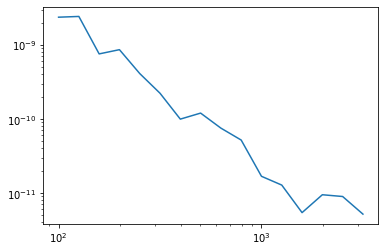

In [509]:
loglog(ell, cell)

In [510]:
# Create our fiducial observations
fiducial_model = condition(model, {'Omega_c':0.2545, 'sigma8':0.801, 'h':0.682, 'w0':-1.,'n_s':0.971})
sample_cell_fiducial = seed(fiducial_model, jax.random.PRNGKey(12345670))
m_data = sample_cell_fiducial()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


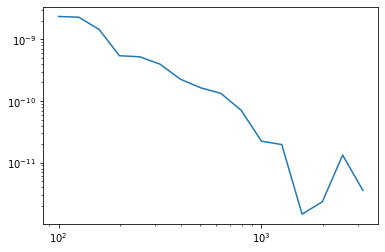

In [511]:
loglog(ell, m_data)

In [512]:
# Ok, so now I can write the joint log prob
def params_log_prob(params):
    Omega_c, s8, h, w0, n_s = params

    cond_model = condition(model, {'Omega_c':Omega_c, 'sigma8': s8, 'h':h, 
                                   'n_s':n_s, 'w0':w0, 'x': m_data})
    model_trace = trace(cond_model).get_trace()
    jointlog = jnp.array([model_trace[k]['fn'].log_prob(model_trace[k]['value']) for k in model_trace.keys()]).sum()
    return jointlog

In [513]:
get_log_prob = jax.jit(jax.vmap(params_log_prob))

In [514]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.9,64),
                 jnp.linspace(0.1,1.1,64)), axis=-1)
ps = jnp.concatenate([p.reshape([-1, 2]), jnp.array([0.682, -1., 0.971]).reshape([1,-1]).repeat(64*64, axis=0)], axis=-1)
p = ps.reshape((64,64,5))

In [515]:
logprob = np.stack([get_log_prob(params) for params in p], axis=0)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


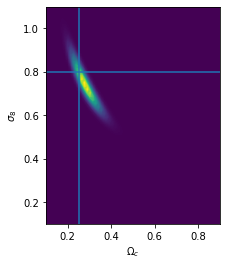

In [516]:
# Plotting the joint prob at x=m_data
contourf(ps[:,0].reshape([64,64]),
         ps[:,1].reshape([64,64]),
         jnp.exp(logprob.reshape([64,64]) - logprob.max()),256)

xlabel('$\Omega_c$')
ylabel('$\sigma_8$')
gca().set_aspect('equal')

axvline(0.2545)
axhline(0.801)

## Fitting procedure

Here is what we'll do:

1. Do MAP to find the most likely point
2. Do a Fisher to find a first Gaussian guess of the distrib
3. Sample a bunch of points from that distrib
4. Fit model
5. Resample more point from where the model find decent mass
6. Iterate

In [517]:
import optax

p0 = jnp.array([0.2545, 0.801, 0.682, -1., 0.971])
fun = lambda p: - params_log_prob(p)

params = p0
optimizer = optax.adam(learning_rate=1e-2)
opt_state = optimizer.init(params)

In [518]:
losses = []

In [519]:
@jax.jit
def update(params, opt_state):
  loss_value, grads = jax.value_and_grad(fun)(params)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss_value

In [520]:
for i in range(200):
  iparams, opt_state, loss_value = update(params, opt_state)

  if ~isnan(iparams.sum()):
    params = iparams
  else:
    break
  losses.append(loss_value)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


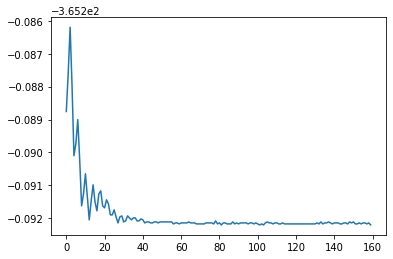

In [521]:
plot(losses[40:])

In [522]:
# Saving MAP
MAP = params

In [523]:
MAP

DeviceArray([ 0.26278555,  0.7509981 ,  0.7270804 , -0.97527283,
              1.0290236 ], dtype=float32)

In [524]:
# Computing Hessian at MAP point
H = jax.hessian(fun)(MAP)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [525]:
H = 0.5*(H + H.T)

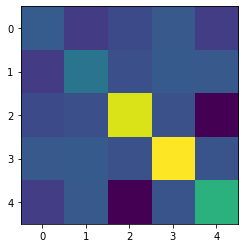

In [526]:
cov = inv(H)
imshow(cov)

In [527]:
diag(cov)

array([0.00249446, 0.00732766, 0.03632929, 0.03930302, 0.02051626],
      dtype=float32)

In [528]:
d = tfd.MultivariateNormalFullCovariance(loc=MAP, covariance_matrix=cov)

In [ ]:
# Ok, so now we can sample a bunch of points from this model
test_samples = d.sample(128, seed=jax.random.PRNGKey(0))

In [529]:
s = d.sample(10000, seed=jax.random.PRNGKey(0))

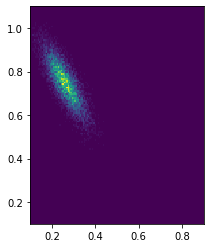

In [530]:
hist2d(s[:,0], s[:,1], 128, range=[[0.1,0.9],[0.1,1.1]]);
gca().set_aspect('equal')

In [534]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.5,64),
                 jnp.linspace(0.5,1.,64)), axis=-1)
ps = jnp.concatenate([p.reshape([-1, 2]), jnp.array(MAP[2:]).reshape([1,-1]).repeat(64*64, axis=0)], axis=-1)
p = ps.reshape((64,64,5))

In [535]:
logprob = np.stack([get_log_prob(params) for params in p], axis=0)

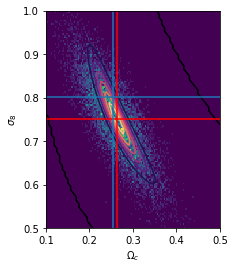

In [542]:
# Plotting the joint prob at x=m_data
hist2d(s[:,0], s[:,1], 128, range=[[0.1,0.5],[0.5,1.]]);
contour(ps[:,0].reshape([64,64]),
         ps[:,1].reshape([64,64]),
         jnp.exp(logprob.reshape([64,64]) - logprob.max()), cmap='magma')

xlabel('$\Omega_c$')
ylabel('$\sigma_8$')
gca().set_aspect('equal')

axvline(MAP[0], color='red')
axhline(MAP[1], color='red')

axvline(0.2545)
axhline(0.801)

In [543]:
score = jax.vmap(jax.grad(params_log_prob))(test_samples) 

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


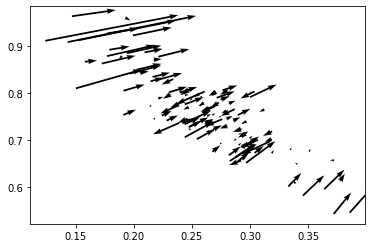

In [544]:
quiver(test_samples[:,0], test_samples[:,1], 
       score[...,0].flatten(), score[...,1].flatten());#, color=colormap(p[:,1]*jnp.sqrt(p[:,0]/0.3)));

# Training a model on this

In [545]:
import haiku as hk
import optax

In [546]:
class NeuralScoreModel(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, p):
    net = hk.Linear(128)(p)
    net = jnp.sin(net)
    net = hk.Linear(128)(net)
    net = jnp.sin(net)
    net = hk.Linear(1)(net)

    return net.squeeze()

In [547]:
siren = hk.without_apply_rng(hk.transform(lambda p : NeuralScoreModel()(p)))

rng_seq = hk.PRNGSequence(12)
params = siren.init(next(rng_seq), jnp.zeros([1, 5]))

In [549]:
def loss_fn(params, batch, score):
  out = jax.vmap(jax.grad(lambda p: siren.apply(params, p.reshape([-1,5]))))(batch) # Here we extract the grad of the model
  return jnp.mean(jnp.sum((out - score)**2, axis=1))

@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [550]:
from tqdm import tqdm
losses = []
master_seed = hk.PRNGSequence(0)

In [584]:
learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [585]:
it = 10000
for step in tqdm(range(it)):
  l, params, opt_state = update(params, opt_state, test_samples, score)
  losses.append(l)

100%|██████████| 10000/10000 [00:03<00:00, 3045.22it/s]


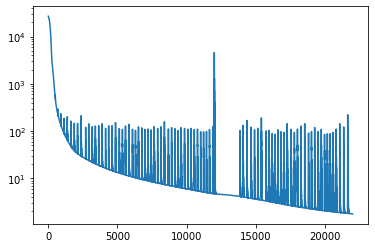

In [586]:
semilogy(array(losses))

In [587]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.5,64),
                 jnp.linspace(0.5,1.,64)), axis=-1)
ps = jnp.concatenate([p.reshape([-1, 2]), jnp.array(MAP[2:]).reshape([1,-1]).repeat(64*64, axis=0)], axis=-1)
p = ps.reshape((64,64,5))

In [588]:
# Getting value of the score as predicted by the NN
pred_fn = siren.apply(params, ps).reshape([64, 64])

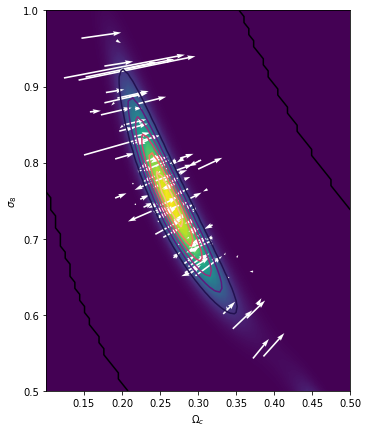

In [589]:
figure(figsize=(7,7))
contourf(p[...,0], p[...,1], np.exp(pred_fn - pred_fn.max()), 256); 
contour(ps[:,0].reshape([64,64]),
         ps[:,1].reshape([64,64]),
         jnp.exp(logprob.reshape([64,64]) - logprob.max()),cmap='magma')

gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

quiver(test_samples[:,0], test_samples[:,1], score[...,0].flatten(), score[...,1].flatten(), color='white');

In [590]:
def unnormalized_log_prob(x):
  x = x.reshape([-1,5])
  return siren.apply(params, x)

# Initialize the HMC transition kernel.
num_results = int(1e4)
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=0.002)

# Run the chain (with burn-in).
@jax.jit
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      current_state=MAP,
      kernel=adaptive_hmc,
      num_steps_between_results=1e1,
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=jax.random.PRNGKey(0))

  return samples, is_accepted

samples, is_accepted = run_chain()

In [591]:
is_accepted.mean()

DeviceArray(0.9981, dtype=float32)

In [597]:
test_samples2 = samples[is_accepted][::100]

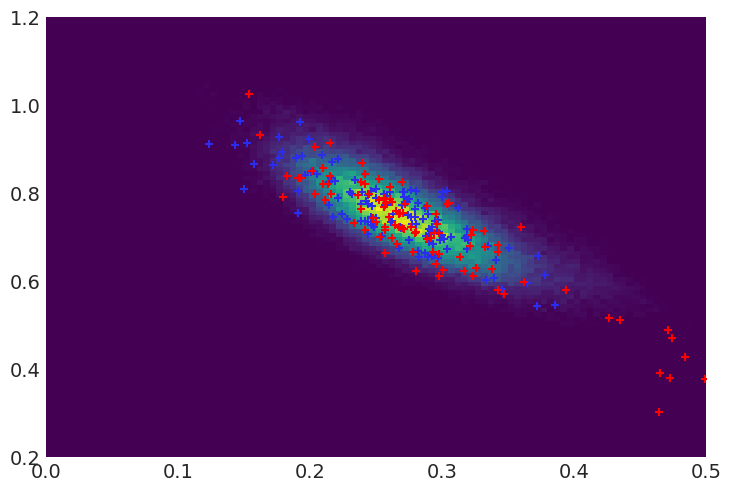

In [650]:
hist2d(samples[is_accepted][:,0], samples[is_accepted][:,1],100,
                                                range=[[0.,0.5],
                                                       [0.2, 1.2]]);
scatter(test_samples[:,0], test_samples[:,1],marker='+')            
scatter(test_samples2[:,0], test_samples2[:,1],marker='+' , color='red')                                           

In [599]:
score2 = jax.vmap(jax.grad(params_log_prob))(test_samples2) 

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [605]:
ts = np.concatenate([test_samples, test_samples2], axis=0)
ss = np.concatenate([score, score2], axis=0)
it = 10000
for step in tqdm(range(it)):
  l, params, opt_state = update(params, opt_state, ts, ss)
  losses.append(l)

100%|██████████| 10000/10000 [00:05<00:00, 1933.84it/s]


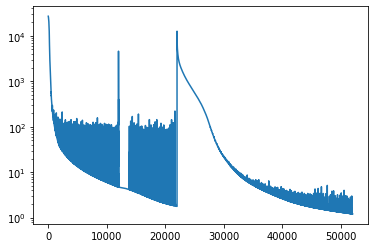

In [606]:
semilogy(array(losses))

In [612]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.0,0.6,64),
                 jnp.linspace(0.2,1.2,64)), axis=-1)
ps = jnp.concatenate([p.reshape([-1, 2]), jnp.array(MAP[2:]).reshape([1,-1]).repeat(64*64, axis=0)], axis=-1)
p = ps.reshape((64,64,5))

In [615]:
logprob = np.stack([get_log_prob(params) for params in p], axis=0)

In [616]:
# Getting value of the score as predicted by the NN
pred_fn = siren.apply(params, ps).reshape([64, 64])

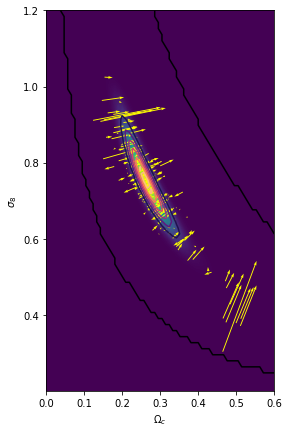

In [617]:
figure(figsize=(7,7))
contourf(p[...,0], p[...,1], np.exp(pred_fn - pred_fn.max()), 256); 
contour(ps[:,0].reshape([64,64]),
         ps[:,1].reshape([64,64]),
         jnp.exp(logprob.reshape([64,64]) - logprob.max()),cmap='magma')

gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

quiver(ts[:,0], ts[:,1], ss[...,0].flatten(), ss[...,1].flatten(), color='yellow');

In [622]:
def unnormalized_log_prob(x):
  x = x.reshape([-1,5])
  return siren.apply(params, x)

# Initialize the HMC transition kernel.
num_results = int(1e5)
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=0.002)

# Run the chain (with burn-in).
@jax.jit
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      current_state=MAP,
      kernel=adaptive_hmc,
      num_steps_between_results=1e1,
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=jax.random.PRNGKey(0))

  return samples, is_accepted

samples, is_accepted = run_chain()

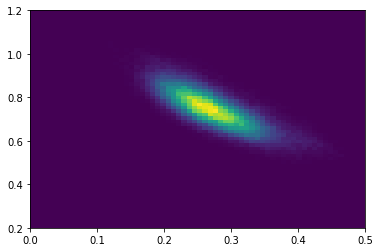

In [640]:
hist2d(samples[is_accepted][:,0], samples[is_accepted][:,1],64,
                                                range=[[0.,0.5],
                                                       [0.2, 1.2]]);                                                  

In [641]:
def unnormalized_log_prob(x):
  return params_log_prob(x)

# Initialize the HMC transition kernel.
num_results = int(1e4)
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=0.02)

# Run the chain (with burn-in).
@jax.jit
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      current_state=MAP,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=jax.random.PRNGKey(0))

  return samples, is_accepted

samples_hmc, is_accepted_hmc = run_chain()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [642]:
is_accepted_hmc.mean()

DeviceArray(0.6778, dtype=float32)

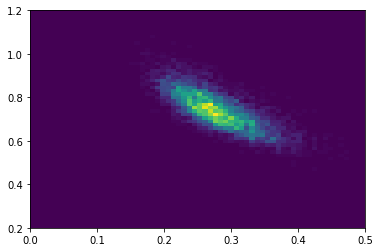

In [643]:
hist2d(samples_hmc[is_accepted_hmc][:,0], samples_hmc[is_accepted_hmc][:,1],64,
                                                range=[[0.,0.5],
                                                       [0.2, 1.2]]);                                                  

In [644]:
import arviz as az

az.style.use("arviz-darkgrid")

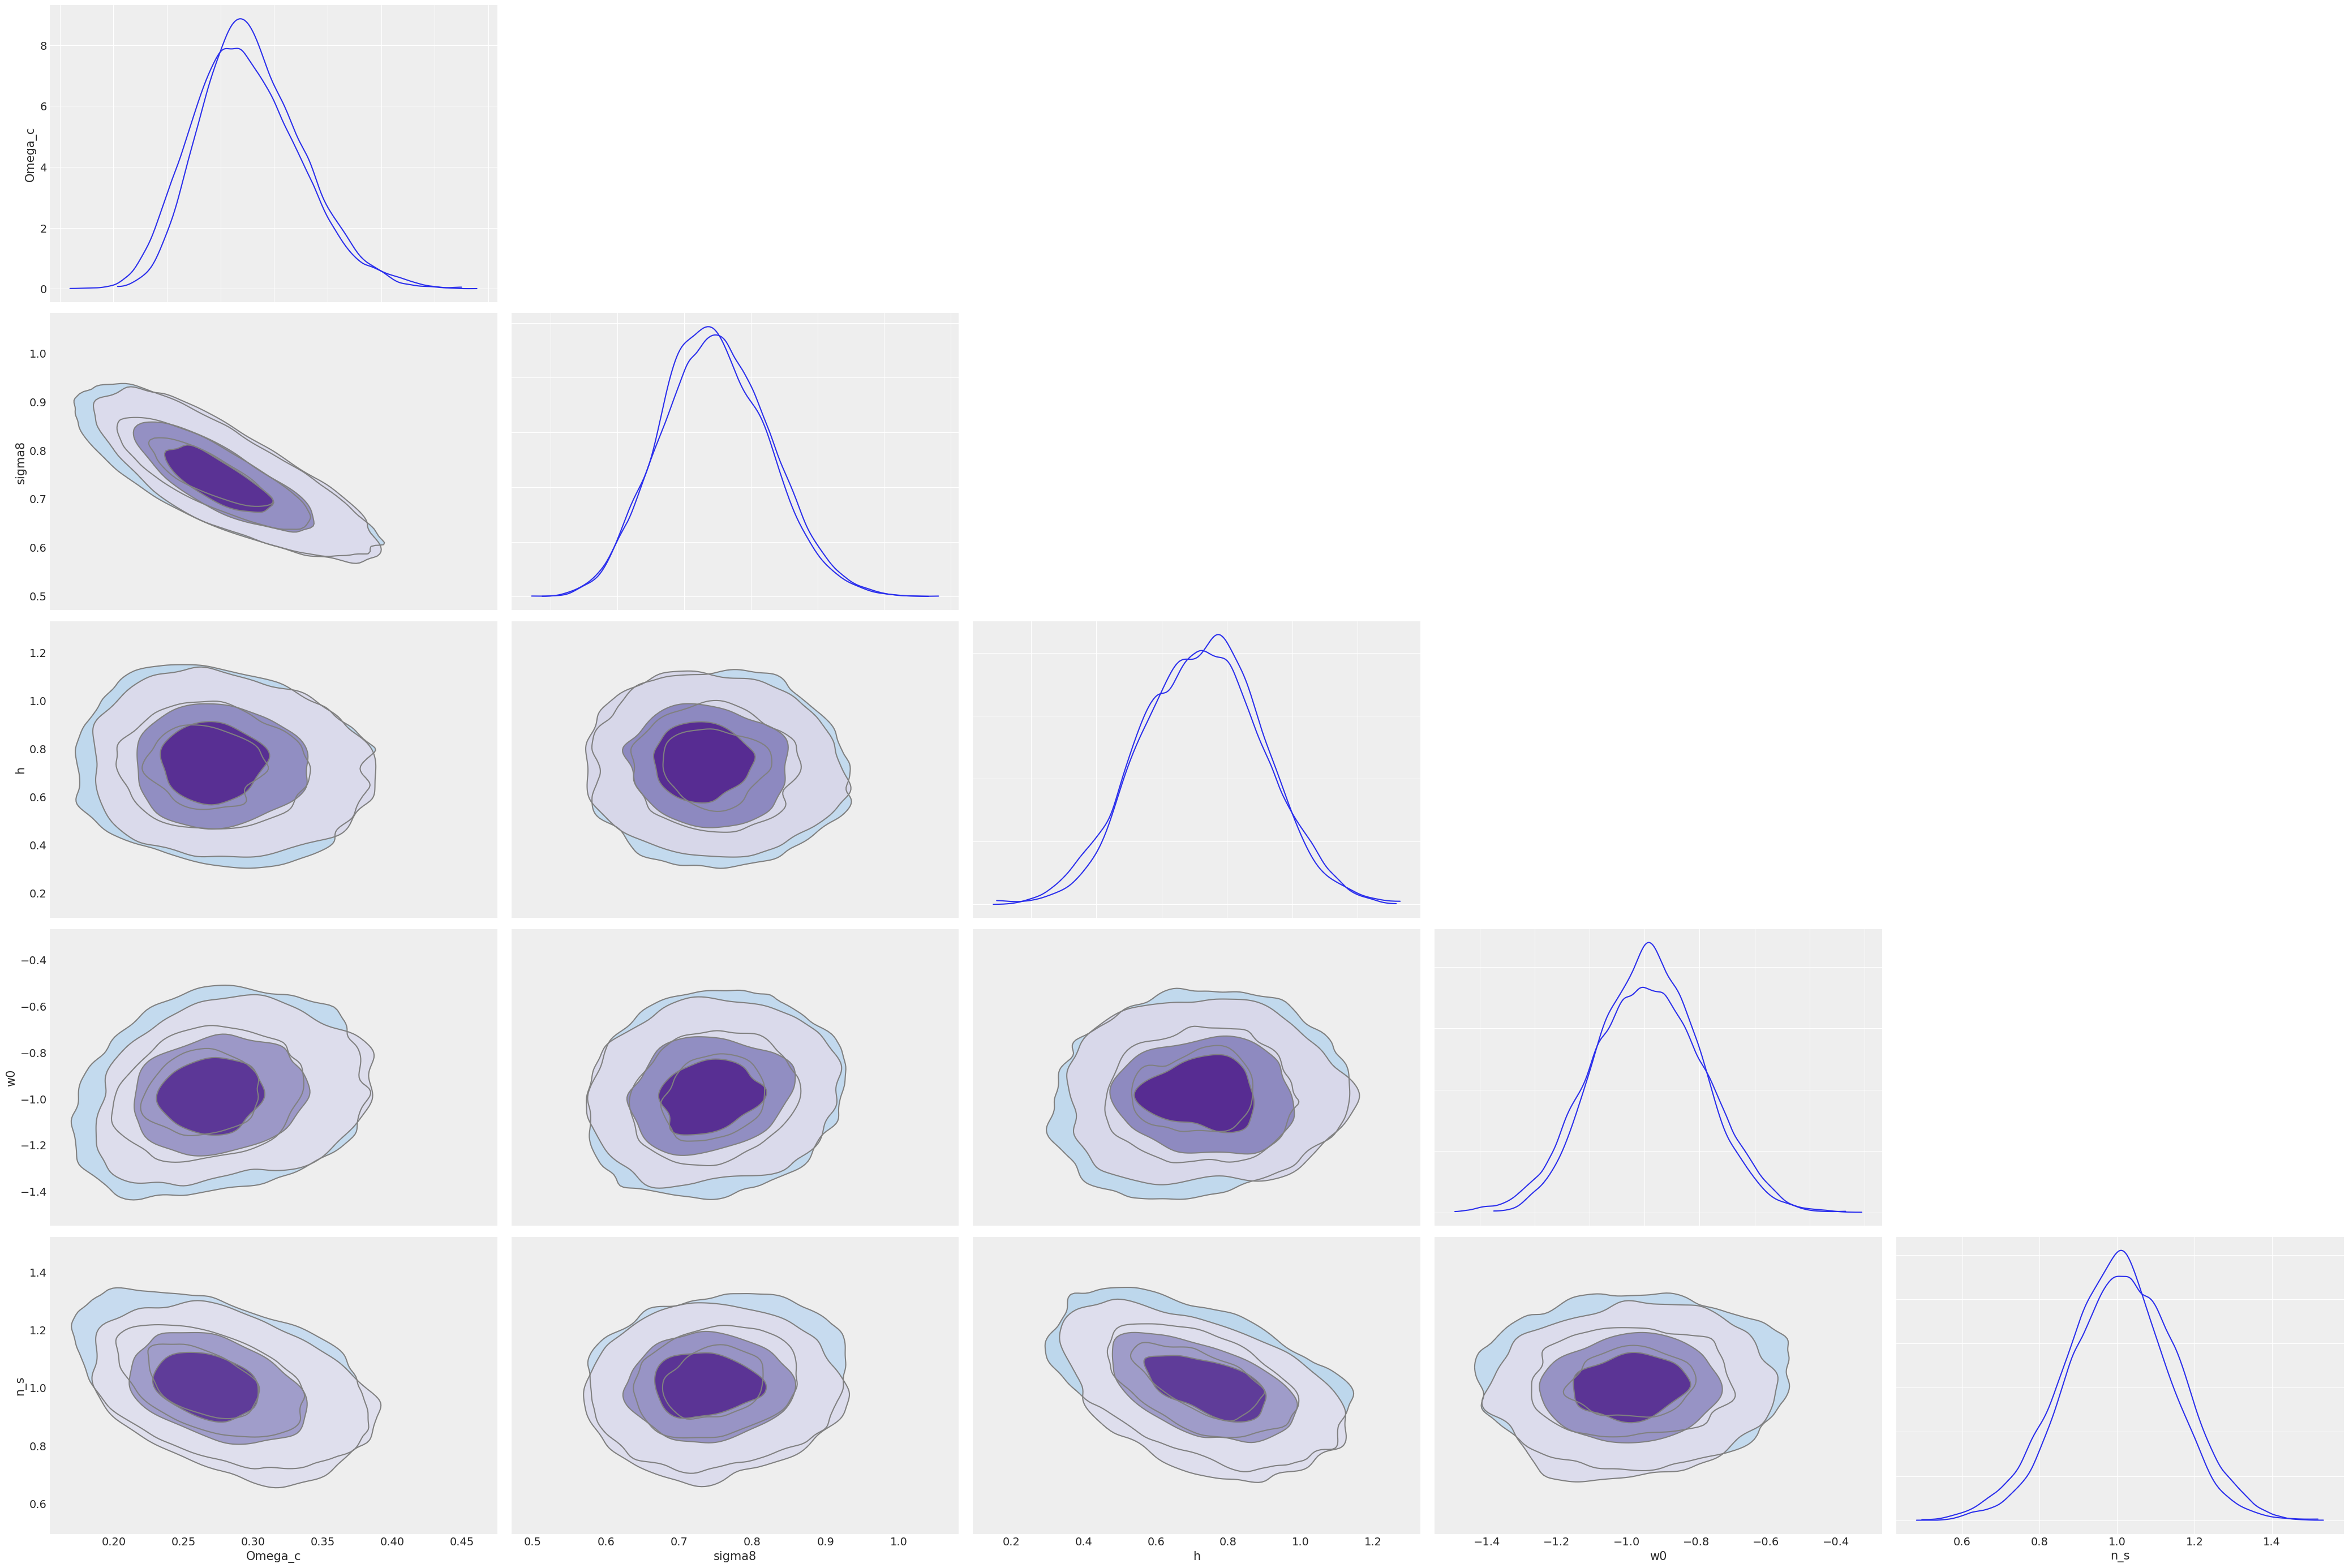

In [647]:
ax = az.plot_pair(
    {k: samples[is_accepted][:,i] for i,k in enumerate(["Omega_c", "sigma8", "h", "w0" ,"n_s"])},
    kind="kde",
        var_names=[
"Omega_c",
"sigma8",
"h",
"w0",
"n_s",],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
);

az.plot_pair(
    {k: samples_hmc[is_accepted_hmc][:,i] for i,k in enumerate(["Omega_c", "sigma8", "h", "w0" ,"n_s"])},
    kind="kde",
    var_names=[
"Omega_c",
"sigma8",
"h",
"w0",
"n_s",],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Purples"},
    },
    marginals=True,
    ax = ax
);

In [649]:
# Posterior fit achieved in this many likelihood calls
len(ts)

228